In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Preparation and Cleansing

- **Create a label quit that would be used for later classification.**
- **Fill the NA values in quit_date with the last day of this dataset, which is December 13, 2015.**
- **Create a new feature tenure_month to calculate the actual tenure after an employee quit, this is the proxy to predict when an employee is more likely to quite.**

In [378]:
data = pd.read_csv('employee_retention.csv')

In [379]:
data['quit'] = data['quit_date'].apply(lambda x: 1 if type(x)==str else 0)

In [380]:
data['quit_date'] = data['quit_date'].fillna('2015-12-13')

In [381]:
data['join_date'] = pd.to_datetime(data['join_date'])
data['quit_date'] = pd.to_datetime(data['quit_date'])

In [382]:
data['tenure_month'] = data['quit_date'] - data['join_date']
data['tenure_month'] = data['tenure_month'].apply(lambda x: x.days)
data['tenure_month'] = data['tenure_month']/30

In [399]:
data[['salary_scaled']] = MinMaxScaler().fit_transform(data[['salary']])
data[['seniority_scaled']] = MinMaxScaler().fit_transform(data[['seniority']])
data[['tenure_month_scaled']] = MinMaxScaler().fit_transform(data[['tenure_month']])

In [384]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,tenure_month
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,19.500000
1,5461,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,11.333333
2,21162,4,marketing,14,101000.0,2014-10-13,2015-12-13,0,14.200000
3,22093,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,12.966667
4,13586,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,34.666667


# Exploratory Data Analysis (EDA)

**Although both groups regardless of quit or not, there was a tendency that the higher the seniority was, the lower churning rate it was, this phenomenon was more obvious for the employees that quit. Because for people who quit, the seniority was clearly less than its counterpart.**

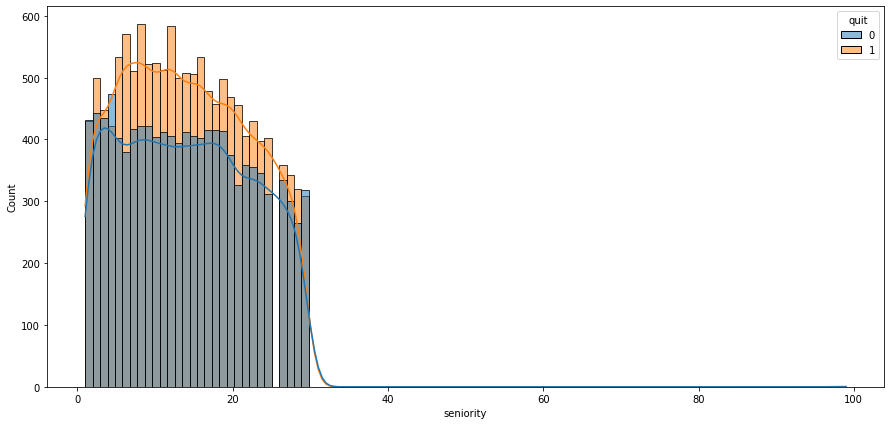

In [385]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.histplot(data=data, x='seniority', hue='quit', kde=True, ax=ax);

**Even though each department had a different employee retention rate, the difference was not very large as they all fell under the range of 51% to 58%, with the lowest from engineering and the highest from sales.**

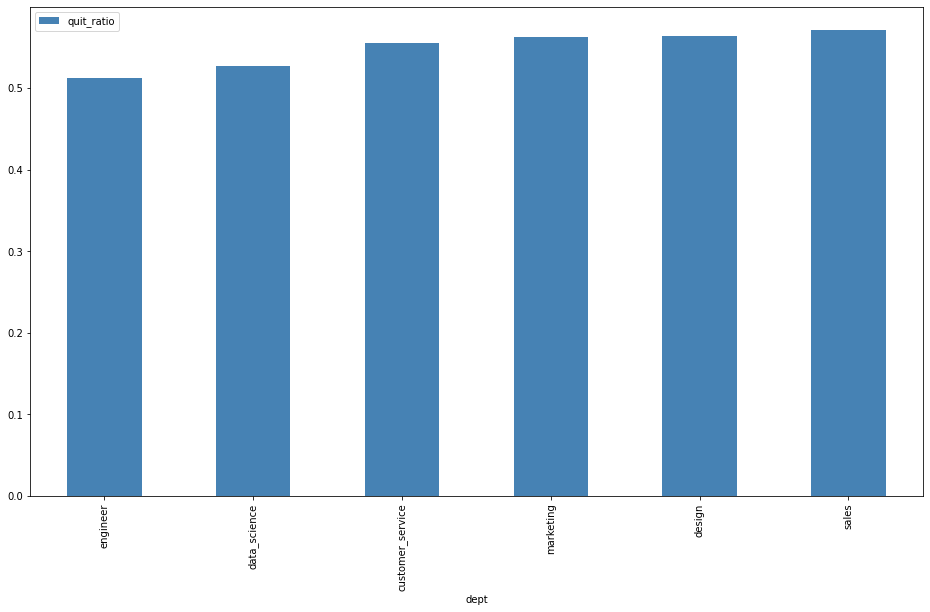

In [386]:
dept_quit = data.groupby('dept').agg({"quit": lambda x: sum(x)/len(x)}).sort_values('quit')
dept_quit.columns = ['quit_ratio']
fig, ax = plt.subplots(figsize=(16, 9))
dept_quit.plot(kind='bar', ax=ax, color='steelblue');

**For occupations with high salaries, such as engineering and data science(darker color), the retention rate was impacted more by salaries compare to the lower income group.**

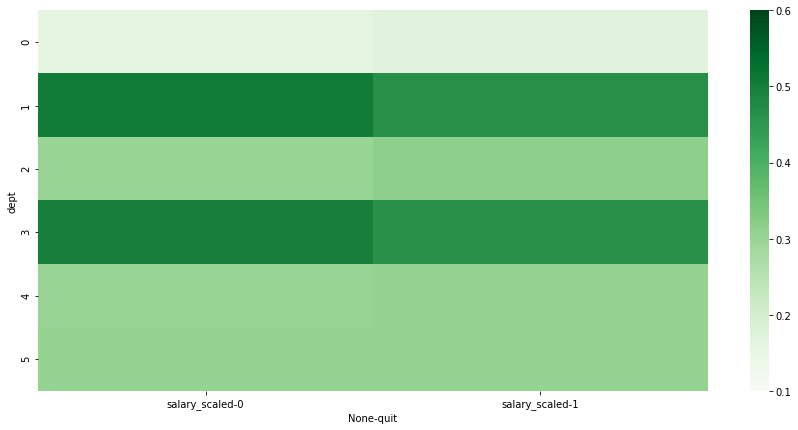

In [400]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(data.pivot_table(index='dept', columns='quit', aggfunc={"salary_scaled": np.mean}), vmin=0.1, vmax=0.6, cmap="Greens");

# Feature Engineering

- **During the exploratory analysis, we found that employees who were less senior in their career were more likely to churn and it alleviated over time, therefore the feature of "seniority_sqrt" is created to depict this phenomenon since it fits a power function with a negative exponent.**
- **The time of a year might affect how long the new employees would stay, for instance, if a employee joined a company in Q1, they might want to wait before the fiscal year ends to obtain their bonus if they wanted to quit.**
- **At the opposite of seniority, employee who were paid more were more likely to churn because of the salary, thus, "salary_square" is created.**
- **How many jobs that an employee had before might suggest how frequently they might change jobs, the feature "jobs_changed" is in place for this one.**

In [388]:
data['seniority_sqrt'] = data['seniority'].apply(np.sqrt)
data['join_quarter'] = data['join_date'].apply(lambda x: (x.month-1)//3+1)
data['salary_square'] = data['salary'] * data['salary']

In [389]:
def counting(grouper):
    
    length = len(grouper)
    grouper['jobs_changed'] = range(length)
    
    return grouper

In [390]:
data = data.groupby('employee_id').apply(lambda x: counting(x))

# Decision Tree

In [391]:
data['dept'] = LabelEncoder().fit_transform(data['dept'])

In [408]:
feature_names = ['company_id','dept','seniority','salary','seniority_sqrt','join_quarter','salary_square','jobs_changed']

In [409]:
X = data[feature_names]
y = data['quit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [410]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=50).fit(X_train, y_train_class)
pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test_class, pred))

Accuracy:  0.5705322809147946


In [395]:
importances = clf.feature_importances_
sorted_importances = np.argsort(importances)
feature_importances = pd.Series(importances, index=feature_names)[sorted_indices][::-1]

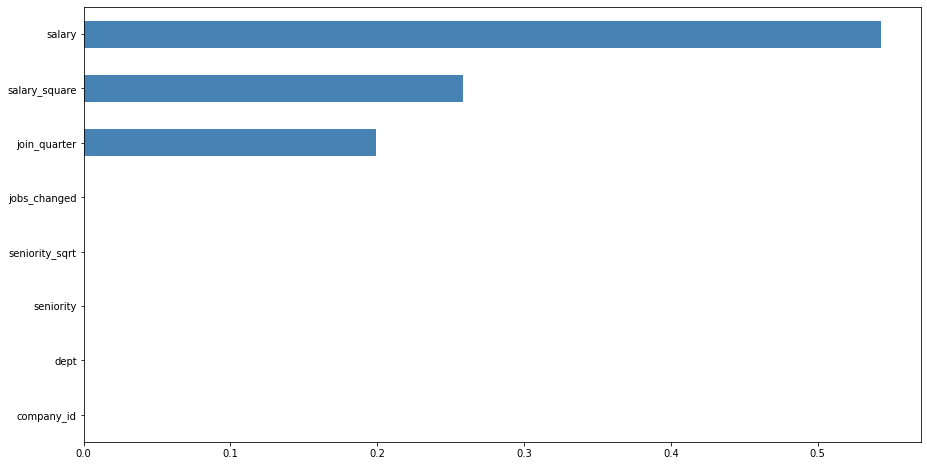

In [396]:
fig, ax = plt.subplots(figsize=(15, 8))
feature_importances.plot(kind='barh', color='steelblue');

**Although there were a few features that might have impact on employee retention, based on the model, it seemed like salary is the dominated factor among all. The join quarter, which was deemed a supplemental factor for salary.**

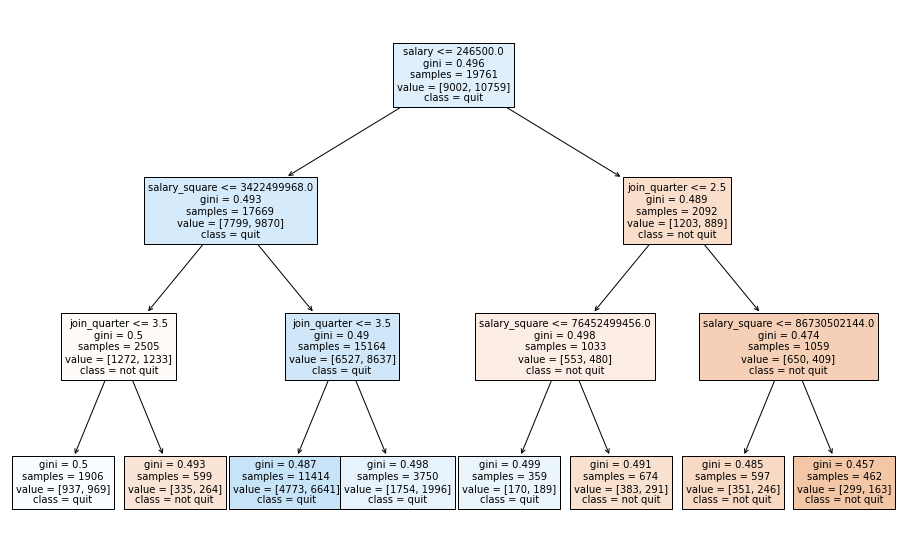

In [397]:
fig, ax = plt.subplots(figsize=(16, 10))
tree.plot_tree(clf, filled=True, fontsize=10, ax=ax, feature_names=feature_names, class_names=['not quit', 'quit']);

**The model suggested people who made more than 246,500 dollars a year were less likely to churn, which made perfect sense. For those who did not, if their income was greater or equal to 58,502 dollars ($\sqrt{3422499968}=58502$), the chance of churning was higher than the other group. Addiontionally, if an employee joined a company before Q4, they were more likely to quit.**

# Neural Network

**The decision tree works well for intepreting which factors are the main drivers of employee retention. However, the model alone could not predict when the employee will quit. The neural network model, on the other hand, works more like a black box that is very difficult to interprete, but it could be complied to predict both wether and when an employee will leave.**

**To predict when an employee will leave, the feature tenure_month is created to represent the duration of a job.**

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Input 
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

In [436]:
data[['salary_square_scaled']] = MinMaxScaler().fit_transform(data[['salary_square']])
data[['seniority_sqrt_scaled']] = MinMaxScaler().fit_transform(data[['seniority_sqrt']])
data[['tenure_month_scaled']] = MinMaxScaler().fit_transform(data[['tenure_month']])

In [426]:
feature_names = ['company_id','dept','seniority_scaled','salary_scaled','seniority_sqrt_scaled','join_quarter',
                 'salary_square_scaled','jobs_changed']

In [437]:
X = data[feature_names]
y = data['tenure_month_scaled']
y_class = data['quit']
n_features = X.shape[1]
n_class = len(np.unique(y_class))

X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(X, y, y_class, test_size=0.2, random_state=1)

In [439]:
model = Sequential()
visible = Input(shape=(n_features,))
hidden1 = Dense(10, activation='relu', kernel_initializer='he_normal')(visible)
hidden2 = Dense(10, activation='relu', kernel_initializer='he_normal')(hidden1)
out_reg = Dense(1, activation='linear')(hidden2)
out_class = Dense(n_class, activation='softmax')(hidden2)

In [440]:
model = Model(inputs=visible, outputs=[out_reg, out_class])
model.compile(loss=['mean_squared_error', 'sparse_categorical_crossentropy'], optimizer='adam')

In [441]:
model.fit(X_train, [y_train, y_train_class], epochs=300, batch_size=256, verbose=2)

Epoch 1/300
78/78 - 0s - loss: 1.9218 - dense_82_loss: 1.1729 - dense_83_loss: 0.7489
Epoch 2/300
78/78 - 0s - loss: 0.8643 - dense_82_loss: 0.1698 - dense_83_loss: 0.6945
Epoch 3/300
78/78 - 0s - loss: 0.7887 - dense_82_loss: 0.0957 - dense_83_loss: 0.6930
Epoch 4/300
78/78 - 0s - loss: 0.7700 - dense_82_loss: 0.0782 - dense_83_loss: 0.6918
Epoch 5/300
78/78 - 0s - loss: 0.7593 - dense_82_loss: 0.0685 - dense_83_loss: 0.6908
Epoch 6/300
78/78 - 0s - loss: 0.7522 - dense_82_loss: 0.0619 - dense_83_loss: 0.6903
Epoch 7/300
78/78 - 0s - loss: 0.7471 - dense_82_loss: 0.0573 - dense_83_loss: 0.6898
Epoch 8/300
78/78 - 0s - loss: 0.7437 - dense_82_loss: 0.0540 - dense_83_loss: 0.6897
Epoch 9/300
78/78 - 0s - loss: 0.7409 - dense_82_loss: 0.0515 - dense_83_loss: 0.6894
Epoch 10/300
78/78 - 0s - loss: 0.7388 - dense_82_loss: 0.0494 - dense_83_loss: 0.6894
Epoch 11/300
78/78 - 0s - loss: 0.7372 - dense_82_loss: 0.0479 - dense_83_loss: 0.6893
Epoch 12/300
78/78 - 0s - loss: 0.7359 - dense_82_lo

Epoch 96/300
78/78 - 0s - loss: 0.7292 - dense_82_loss: 0.0414 - dense_83_loss: 0.6879
Epoch 97/300
78/78 - 0s - loss: 0.7295 - dense_82_loss: 0.0415 - dense_83_loss: 0.6879
Epoch 98/300
78/78 - 0s - loss: 0.7290 - dense_82_loss: 0.0414 - dense_83_loss: 0.6876
Epoch 99/300
78/78 - 0s - loss: 0.7292 - dense_82_loss: 0.0414 - dense_83_loss: 0.6878
Epoch 100/300
78/78 - 0s - loss: 0.7291 - dense_82_loss: 0.0413 - dense_83_loss: 0.6878
Epoch 101/300
78/78 - 0s - loss: 0.7293 - dense_82_loss: 0.0413 - dense_83_loss: 0.6880
Epoch 102/300
78/78 - 0s - loss: 0.7288 - dense_82_loss: 0.0413 - dense_83_loss: 0.6875
Epoch 103/300
78/78 - 0s - loss: 0.7292 - dense_82_loss: 0.0414 - dense_83_loss: 0.6878
Epoch 104/300
78/78 - 0s - loss: 0.7289 - dense_82_loss: 0.0413 - dense_83_loss: 0.6875
Epoch 105/300
78/78 - 0s - loss: 0.7290 - dense_82_loss: 0.0415 - dense_83_loss: 0.6876
Epoch 106/300
78/78 - 0s - loss: 0.7287 - dense_82_loss: 0.0413 - dense_83_loss: 0.6874
Epoch 107/300
78/78 - 0s - loss: 0.7

Epoch 190/300
78/78 - 0s - loss: 0.7265 - dense_82_loss: 0.0413 - dense_83_loss: 0.6851
Epoch 191/300
78/78 - 0s - loss: 0.7262 - dense_82_loss: 0.0413 - dense_83_loss: 0.6849
Epoch 192/300
78/78 - 0s - loss: 0.7265 - dense_82_loss: 0.0413 - dense_83_loss: 0.6852
Epoch 193/300
78/78 - 0s - loss: 0.7263 - dense_82_loss: 0.0412 - dense_83_loss: 0.6850
Epoch 194/300
78/78 - 0s - loss: 0.7262 - dense_82_loss: 0.0411 - dense_83_loss: 0.6851
Epoch 195/300
78/78 - 0s - loss: 0.7264 - dense_82_loss: 0.0415 - dense_83_loss: 0.6849
Epoch 196/300
78/78 - 0s - loss: 0.7261 - dense_82_loss: 0.0412 - dense_83_loss: 0.6850
Epoch 197/300
78/78 - 0s - loss: 0.7261 - dense_82_loss: 0.0412 - dense_83_loss: 0.6849
Epoch 198/300
78/78 - 0s - loss: 0.7269 - dense_82_loss: 0.0416 - dense_83_loss: 0.6853
Epoch 199/300
78/78 - 0s - loss: 0.7260 - dense_82_loss: 0.0411 - dense_83_loss: 0.6848
Epoch 200/300
78/78 - 0s - loss: 0.7261 - dense_82_loss: 0.0413 - dense_83_loss: 0.6849
Epoch 201/300
78/78 - 0s - loss:

78/78 - 0s - loss: 0.7252 - dense_82_loss: 0.0411 - dense_83_loss: 0.6841
Epoch 284/300
78/78 - 0s - loss: 0.7250 - dense_82_loss: 0.0411 - dense_83_loss: 0.6839
Epoch 285/300
78/78 - 0s - loss: 0.7248 - dense_82_loss: 0.0410 - dense_83_loss: 0.6838
Epoch 286/300
78/78 - 0s - loss: 0.7250 - dense_82_loss: 0.0411 - dense_83_loss: 0.6839
Epoch 287/300
78/78 - 0s - loss: 0.7250 - dense_82_loss: 0.0411 - dense_83_loss: 0.6839
Epoch 288/300
78/78 - 0s - loss: 0.7249 - dense_82_loss: 0.0411 - dense_83_loss: 0.6839
Epoch 289/300
78/78 - 0s - loss: 0.7252 - dense_82_loss: 0.0412 - dense_83_loss: 0.6840
Epoch 290/300
78/78 - 0s - loss: 0.7254 - dense_82_loss: 0.0412 - dense_83_loss: 0.6841
Epoch 291/300
78/78 - 0s - loss: 0.7246 - dense_82_loss: 0.0410 - dense_83_loss: 0.6836
Epoch 292/300
78/78 - 0s - loss: 0.7251 - dense_82_loss: 0.0413 - dense_83_loss: 0.6838
Epoch 293/300
78/78 - 0s - loss: 0.7246 - dense_82_loss: 0.0411 - dense_83_loss: 0.6835
Epoch 294/300
78/78 - 0s - loss: 0.7249 - dens

In [442]:
yhat1, yhat2 = model.predict(X_test)
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f'% error)

MAE: 0.162


In [443]:
yhat2 = np.argmax(yhat2, axis=-1).astype('int')
accuracy = accuracy_score(y_test_class, yhat2)
print("Accuracy: %.3f" % accuracy)

Accuracy: 0.562


# Conclusion

- **The model suggest that employees paid in middle range of income (such as engineers, data scientists) were more likely to quit and the main drivers were compensation related.**
- **Due to lack of effective features, the accuracy of the model prediction was not superior, only 57% approximately, which is just slightly better than random guesses.**
- **To improve the performance of the model, more meaningful data should be collected. Variables such as the amount of training, work-lefe banlance and benefits, just to name a few, however, if there is only variable could be selected, I would recommend to quantify employee engagement, because it might be an leading indicator that tells the clue.**